In [38]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import sympy
sympy.init_printing()

from IPython.display import display

import numpy

import sys
sys.path.insert(0, './code')

from gauss_legendre import gauss_legendre
from symbolic import eval_expr
from evaluate_functional import evaluate_functional
import ideal_gas_lumped

### macroscopic state

In [39]:
q = sympy.Symbol('q')
p = sympy.Symbol('p')
s_1 = sympy.Symbol('s_1')
s_2 = sympy.Symbol('s_2')

x = [q, p, s_1, s_2]
x

### parameters

In [67]:
l = sympy.Symbol('l')
r = sympy.Symbol('r')
w = sympy.Symbol('w')
A = sympy.Symbol('A')

m_Al = sympy.Symbol('m_Al')
m_Cu = sympy.Symbol('m_Cu')
m = sympy.Symbol('m')

κ_Al = sympy.Symbol('κ_Al')
κ_Cu = sympy.Symbol('κ_Cu')
α = sympy.Symbol('α')

d = sympy.Symbol('d')

params = {
    # length of cylinder (m)
    l: 0.1,
    
    # radius of cylinder / piston (m)
    r: 0.05,

    # length of piston (m)
    w: 0.006,
    
    # cross-sectional area of piston (m**2) 
    A: r**2 * sympy.pi,

    # density of piston material (kg/m**3)
    m_Al: 2700.0,
    m_Cu: 8960.0,
    
    # mass of piston (kg)
    m: m_Cu * A * w,

    # thermal conductivity piston material (W/(m*K))
    κ_Al: 237.0,
    κ_Cu: 401.0,
    
    # thermal conduction coefficient through piston (W/K)
    α: κ_Cu * A / w,
    
    # friction coefficient between piston and cylinder (N*s/m)
    d: 1.0,
}

params = {**params, **ideal_gas_lumped.params}

### functionals

In [41]:
functionals = {}

v_1 = sympy.Symbol('v_1') # volume (m**3)
functionals[v_1] = A * (q - (w/2))

U_1 = sympy.Symbol('U_1') # internal energy
m_1 = sympy.Symbol('m_1') # fixed mass (kg)
θ_1 = sympy.Symbol('θ_1') # temperature (K)
π_1 = sympy.Symbol('π_1') # pressure (Pa)
ideal_gas_lumped.add_functionals(functionals, U=U_1, s=s_1, v=v_1, m=m_1, m_a=ideal_gas_lumped.m_Ar, θ=θ_1, π=π_1)

v_2 = sympy.Symbol('v_2')
functionals[v_2] = A * (l - (q + w/2))

U_2 = sympy.Symbol('U_2')
m_2 = sympy.Symbol('m_2')
θ_2 = sympy.Symbol('θ_2')
π_2 = sympy.Symbol('π_2')
ideal_gas_lumped.add_functionals(functionals, U=U_2, s=s_2, v=v_2, m=m_2, m_a=ideal_gas_lumped.m_Ar, θ=θ_2, π=π_2)

υ = sympy.Symbol('υ')
functionals[υ] = p / m

E = sympy.Symbol('E') # total energy (J)
functionals[E] = sympy.Rational(1,2) * p**2 / m + U_1 + U_2

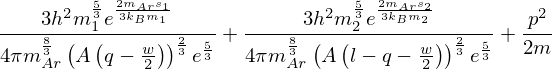

In [42]:
eval_expr(E, functionals)

### initial conditions

determine $m_1$, $m_2$ and $s_1(0)$, $s_2(0)$

In [43]:
# wanted conditions
q0 = params[l]/2
v_10 = float(eval_expr(v_1, functionals, params, {q: q0}))
v_20 = float(eval_expr(v_2, functionals, params, {q: q0}))

θ_10 = 273.15 + 25.0
π_10 = 1.5 * 1e5

θ_20 = 273.15 + 20.0
π_20 = 1.0 * 1e5

In [44]:
import ideal_gas
from scipy.optimize import fsolve

In [45]:
n_10 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_10, n), v_10, n) - π_10, x0=2e22)[0]
s_10 = ideal_gas.S(ideal_gas.U2(θ_10, n_10), v_10, n_10)
print(f"n = {n_10}")
print(f"s = {s_10}")
print(f"θ = {ideal_gas.U_θ(s_10, v_10, n_10) - 273.15} °C")
print(f"π = {ideal_gas.U_π(s_10, v_10, n_10) * 1e-5} bar")
print(f"u = {ideal_gas.U(s_10, v_10, n_10)}")

n = 1.345119603317771e+22
s = 3.3828942208847232
θ = 25.00000000000159 °C
π = 1.500000000000008 bar
u = 83.05585577928


In [46]:
n_20 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_20, n), v_20, n) - π_20, x0=2e22)[0]
s_20 = ideal_gas.S(ideal_gas.U2(θ_20, n_20), v_20, n_20)
print(f"n = {n_20}")
print(f"s = {s_20}")
print(f"θ = {ideal_gas.U_θ(s_20, v_20, n_20) - 273.15} °C")
print(f"π = {ideal_gas.U_π(s_20, v_20, n_20) * 1e-5} bar")
print(f"u = {ideal_gas.U(s_20, v_20, n_20)}")

n = 9.12041411630436e+21
s = 2.3394613409617664
θ = 20.000000000004206 °C
π = 1.0000000000000147 bar
u = 55.37057051952051


In [72]:
x_0 = [q0, 0, s_10, s_20]
params[m_1] = n_10 * ideal_gas_lumped.m_Ar
params[m_2] = n_20 * ideal_gas_lumped.m_Ar

### dynamics

In [48]:
x

In [92]:
F = [υ, A*(π_1 - π_2) - d*υ, (α*(θ_2 - θ_1) + d*υ**2/2)/θ_1, (α*(θ_1 - θ_2) + d*υ**2/2)/θ_2]
F

In [93]:
t_f = 0.8
dt = 1e-3
s = 2
print(f"K = {int(t_f // dt)}")

K = 800


In [94]:
%time time, solution = gauss_legendre(x, F, x_0, t_f, dt, s, functionals, params)

CPU times: user 2.39 s, sys: 7.89 ms, total: 2.4 s
Wall time: 2.4 s


In [83]:
sol = solution.copy()

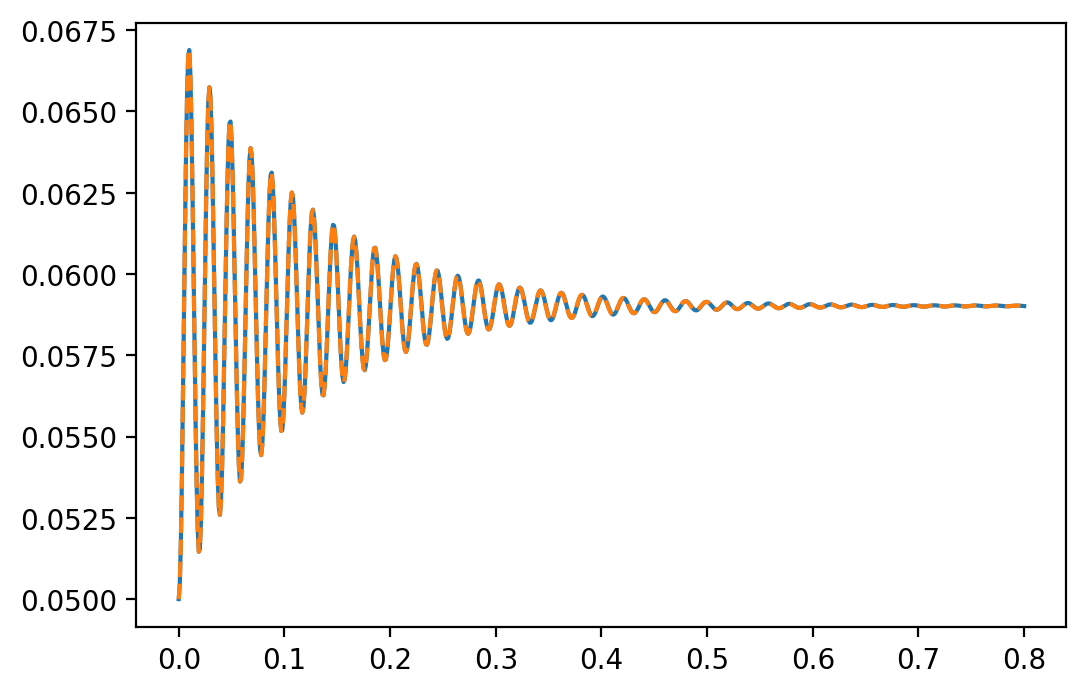

In [87]:
fig, ax = plt.subplots(dpi=200)
ax.plot(time,solution[:, 0]);
ax.plot(time,sol[:, 0], '--');

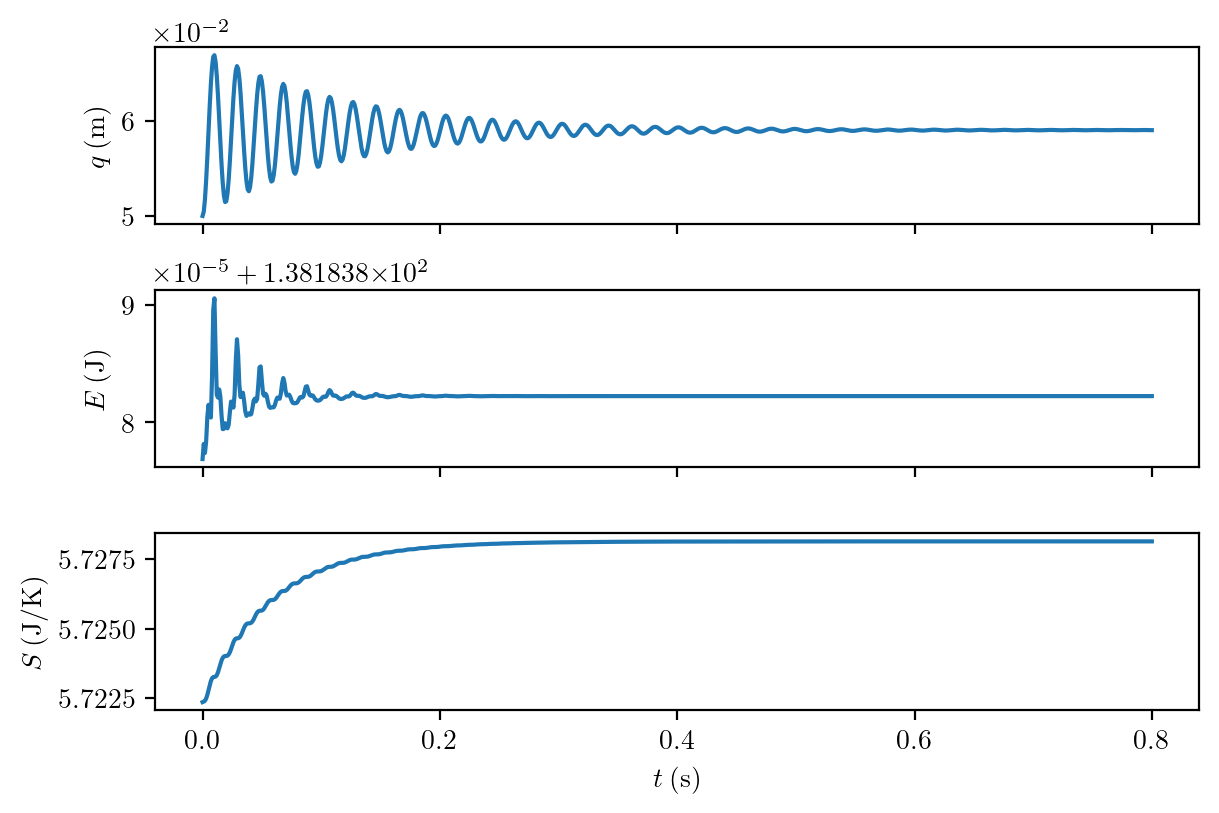

In [130]:
energy = evaluate_functional(x, E, solution, functionals, params)
S = s_1 + s_2
entropy = evaluate_functional(x, S, solution, functionals, params)

fig, axes = plt.subplots(nrows=3, sharex=True, dpi=200)
fig.tight_layout(pad=1.5)

#axes[0].set_title(f"time step = {dt}")

axes[0].plot(time, solution[:, 0])
axes[0].set_ylabel("$q \: (\mathrm{m})$")
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].xaxis.major.formatter._useMathText = True

axes[1].plot(time, energy)
axes[1].set_ylabel("$E \: (\mathrm{J})$")
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

axes[2].plot(time, entropy)
axes[2].set_xlabel("$t \: (\mathrm{s})$")
axes[2].set_ylabel("$S \: (\mathrm{J}/\mathrm{K})$");
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

fig.savefig("simulation.pdf")

In [97]:
import matplotlib
import matplotlib.animation as anim


def animate(solution, functionals, params, file):
    plt.ioff()

    r2 = 2 * params[r]
    w2 = params[w] / 2
    l2 = params[l] - w2

    cmap = matplotlib.cm.get_cmap('YlOrRd')

    fig, ax = plt.subplots(dpi=200)
    ax.set_xlim(left=0, right=params[l])
    ax.set_ylim(bottom=-params[r], top=params[r])

    q0 = params[l]/2
    vol1 = plt.Rectangle((0, -params[r]), q0-w2, r2, fc='b')
    ax.add_patch(vol1)
    pist = plt.Rectangle((q0-w2, -params[r]), params[w], r2, fc='#C84843')
    ax.add_patch(pist)
    vol2 = plt.Rectangle((q0+w2, -params[r]), l2-q0, r2, fc='g')
    ax.add_patch(vol2)

    θ_1sol = evaluate_functional(x, θ_1, solution, functionals, params)
    θ_2sol = evaluate_functional(x, θ_2, solution, functionals, params)
    θ_min = numpy.min([numpy.min(θ_1sol), numpy.min(θ_2sol)])
    θ_max = numpy.max([numpy.max(θ_1sol), numpy.max(θ_2sol)])
    θ_swing = θ_max - θ_min

    data = numpy.block([solution, θ_1sol.reshape(-1,1), θ_2sol.reshape(-1,1)])

    def animate(datum):
        qd = datum[0]
        θ_1d = datum[4]
        θ_2d = datum[5]

        l_1 = qd - w2
        l_2 = l2 - qd

        vol1.set_width(l_1)
        pist.set_x(l_1)
        vol2.set_x(l_1 + params[w])
        vol2.set_width(l_2)

        vol1.set_fc(cmap(0.8 * ((θ_1d-θ_min) / θ_swing)))
        vol2.set_fc(cmap(0.8 * ((θ_2d-θ_min) / θ_swing)))

        return (vol1, pist, vol2)

    animation = anim.FuncAnimation(fig, animate, frames=data, blit=True, repeat=False)
    animation.save(file, fps=20, extra_args=['-vcodec', 'libx264'])
    plt.close(fig)

In [98]:
%time animate(solution[:4000], functionals, params, 'piston.mp4')

CPU times: user 26.9 s, sys: 1.39 s, total: 28.3 s
Wall time: 28.9 s
